# COST 2100 Dataset Analysis

Structure: setup → data loading → preprocessing → analysis.

## 1. Setup and dataset download

In [1]:
import kagglehub
import os
import shutil
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

In [2]:
figs_dir = "data_figs"
os.makedirs(figs_dir, exist_ok=True)

In [3]:
# 1. Download latest version of the dataset (only if not yet downloaded)
print("Downloading dataset through KaggleHub...")
path = kagglehub.dataset_download("forment/cost2100")
print("Downloaded to:", path)

# 2. Create local folder ./dataset inside the project
dst_path = "./dataset"
os.makedirs(dst_path, exist_ok=True)

# 3. Copy .mat files ONLY if they do NOT already exist
copied = 0
skipped = 0

for root, dirs, files in os.walk(path):
    for filename in files:
        if filename.endswith(".mat"):
            src_file = os.path.join(root, filename)
            dst_file = os.path.join(dst_path, filename)

            # Check if file is already copied
            if os.path.exists(dst_file):
                print(f"[SKIP] {filename} already exists")
                skipped += 1
                continue

            shutil.copy(src_file, dst_file)
            print(f"[COPY] {filename}")
            copied += 1

print("\nSummary:")
print(f"  Copied files: {copied}")
print(f"  Skipped files (already exist): {skipped}")
print("Dataset folder:", os.path.abspath(dst_path))
print("Files:", os.listdir(dst_path))

Downloaded to: /home/cvaca/.cache/kagglehub/datasets/forment/cost2100/versions/1
[SKIP] DATA_Htestin.mat already exists
[SKIP] DATA_Htrainout.mat already exists
[SKIP] DATA_Hvalout.mat already exists
[SKIP] DATA_Htestout.mat already exists
[SKIP] DATA_Htrainin.mat already exists
[SKIP] DATA_HtestFin_all.mat already exists
[SKIP] DATA_Hvalin.mat already exists
[SKIP] DATA_HtestFout_all.mat already exists

Summary:
  Copied files: 0
  Skipped files (already exist): 8
Dataset folder: /home/cvaca/Assignment/dataset
Files: ['DATA_Htestin.mat', 'DATA_Htrainout.mat', 'DATA_Hvalout.mat', 'DATA_Htestout.mat', 'DATA_Htrainin.mat', 'DATA_HtestFin_all.mat', 'DATA_Hvalin.mat', 'DATA_HtestFout_all.mat']


In [4]:
dataset_list = os.listdir(dst_path)
dataset_list

['DATA_Htestin.mat',
 'DATA_Htrainout.mat',
 'DATA_Hvalout.mat',
 'DATA_Htestout.mat',
 'DATA_Htrainin.mat',
 'DATA_HtestFin_all.mat',
 'DATA_Hvalin.mat',
 'DATA_HtestFout_all.mat']

In [5]:
# Checking the structure of the mat file
mat = sio.loadmat(os.path.join(dst_path, "DATA_Htrainin.mat"))
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'HT'])


## 2. Load raw indoor and outdoor CSI datasets

In [6]:
# Load indoor sets
H_train_in   = sio.loadmat(os.path.join(dst_path, "DATA_Htrainin.mat"))["HT"]
H_val_in     = sio.loadmat(os.path.join(dst_path, "DATA_Hvalin.mat"))["HT"]
H_test_in    = sio.loadmat(os.path.join(dst_path, "DATA_Htestin.mat"))["HT"]

# Load outdoor sets
H_train_out  = sio.loadmat(os.path.join(dst_path, "DATA_Htrainout.mat"))["HT"]
H_val_out    = sio.loadmat(os.path.join(dst_path, "DATA_Hvalout.mat"))["HT"]
H_test_out   = sio.loadmat(os.path.join(dst_path, "DATA_Htestout.mat"))["HT"]

print("Indoor train shape :", H_train_in.shape)
print("Indoor val shape   :", H_val_in.shape)
print("Indoor test shape  :", H_test_in.shape)
print("Outdoor train shape:", H_train_out.shape)
print("Outdoor val shape  :", H_val_out.shape)
print("Outdoor test shape :", H_test_out.shape)

Indoor train shape : (100000, 2048)
Indoor val shape   : (30000, 2048)
Indoor test shape  : (20000, 2048)
Outdoor train shape: (100000, 2048)
Outdoor val shape  : (30000, 2048)
Outdoor test shape : (20000, 2048)


In [7]:
H = H_train_in  # or any dataset array
print("Global min:", H.min())
print("Global max:", H.max())

Global min: 3.634970657806491e-10
Global max: 0.9999999999999383


## 3. Reshape and denormalize to $(2, 32, 32)$ tensors

In [8]:
# The vector length 2048 corresponds to a reshaped CSI tensor of size (2, 32, 32):
#  - 32 delay-domain taps (after truncation)
#  - 32 BS antennas
#  - 2 channels (real and imaginary parts)
#
# This (2, 32, 32) representation is the standard input format used in the original CsiNet paper.
# Therefore, each sample is reshaped into (2, 32, 32) for further analysis
# and for training the autoencoder model.

IMG_C, IMG_H, IMG_W = 2, 32, 32   # (channels, delay, angle/antenna)

def reshape_ht(ht):
    """ht: (N, 2048) -> (N, 2, 32, 32)"""
    return ht.reshape(-1, IMG_C, IMG_H, IMG_W)
def denormalize_HT(X):
    X = X.copy()
    X[:,0,:,:] -= 0.5    # real
    X[:,1,:,:] -= 0.5    # imag
    return X

X_train_in  = denormalize_HT(reshape_ht(H_train_in))
X_train_out = denormalize_HT(reshape_ht(H_train_out))

print("Indoor reshaped :", X_train_in.shape)
print("Outdoor reshaped:", X_train_out.shape)

Indoor reshaped : (100000, 2, 32, 32)
Outdoor reshaped: (100000, 2, 32, 32)


In [9]:
H = X_train_in  # or any dataset array
print("Global min:", H.min())
print("Global max:", H.max())

Global min: -0.49999999963650293
Global max: 0.49999999999993827


## 4. Magnitude representation and basic statistics

In [10]:
def to_magnitude(X):
    # X: (N, 2, 32, 32)  [0]=real, [1]=imag
    real = X[:, 0]
    imag = X[:, 1]
    return np.sqrt(real**2 + imag**2)   # (N, 32, 32)

mag_in  = to_magnitude(X_train_in)
mag_out = to_magnitude(X_train_out)

print("Indoor magnitude shape :", mag_in.shape)
print("Outdoor magnitude shape:", mag_out.shape)

Indoor magnitude shape : (100000, 32, 32)
Outdoor magnitude shape: (100000, 32, 32)


In [11]:
print("Indoor |H| min:", mag_in.min(), "max:", mag_in.max())
print("Outdoor |H| min:", mag_out.min(), "max:", mag_out.max())

Indoor |H| min: 2.2744789836215303e-08 max: 0.5000000000000001
Outdoor |H| min: 6.625477896682924e-07 max: 0.5000000000000001


## 5. Sparsity in delay and angle domains

In [12]:
# Power = |H|^2
pow_in  = mag_in**2
pow_out = mag_out**2

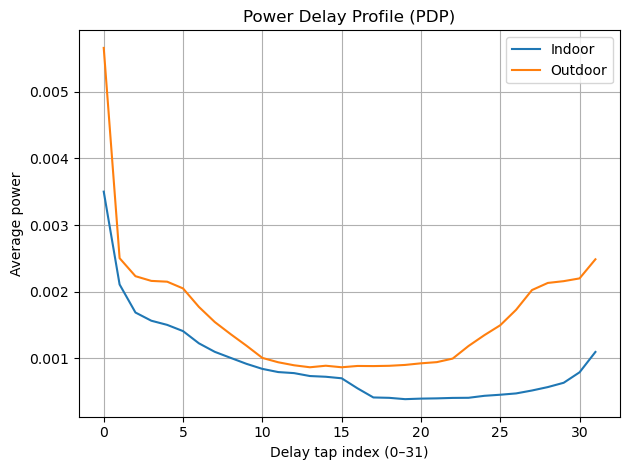

In [13]:
# Average power per delay tap: average over (samples, angle)
delay_pdp_in  = pow_in.mean(axis=(0, 2))   # shape (32,)
delay_pdp_out = pow_out.mean(axis=(0, 2))  # shape (32,)

plt.figure()
plt.plot(delay_pdp_in,  label="Indoor")
plt.plot(delay_pdp_out, label="Outdoor")
plt.xlabel("Delay tap index (0–31)")
plt.ylabel("Average power")
plt.title("Power Delay Profile (PDP)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(figs_dir + "/Power_delay_profile.png")
plt.show()

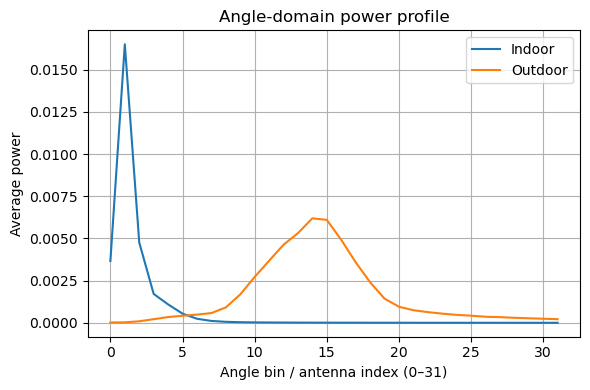

In [14]:
# Average power per angle bin: average over (samples, delay)
angle_pdp_in  = pow_in.mean(axis=(0, 1))   # shape (32,)
angle_pdp_out = pow_out.mean(axis=(0, 1))  # shape (32,)

plt.figure(figsize=(6,4))
plt.plot(angle_pdp_in,  label="Indoor")
plt.plot(angle_pdp_out, label="Outdoor")
plt.xlabel("Angle bin / antenna index (0–31)")
plt.ylabel("Average power")
plt.title("Angle-domain power profile")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(figs_dir + "/Angle_power_profile.png")
plt.show()


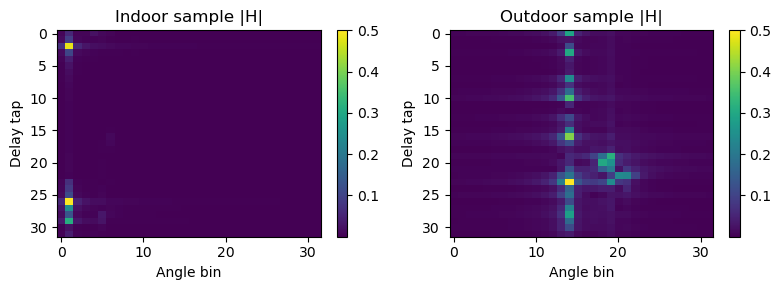

In [15]:
def show_sample_heatmaps(mag_in, mag_out, idx_in=0, idx_out=0):
    plt.figure(figsize=(8,3))

    plt.subplot(1,2,1)
    plt.imshow(mag_in[idx_in], aspect='auto')
    plt.title("Indoor sample |H|")
    plt.xlabel("Angle bin")
    plt.ylabel("Delay tap")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(mag_out[idx_out], aspect='auto')
    plt.title("Outdoor sample |H|")
    plt.xlabel("Angle bin")
    plt.ylabel("Delay tap")
    plt.colorbar()

    plt.tight_layout()
    plt.savefig(figs_dir + "/heat_map_" + str(idx_in) + "_" + str(idx_out) +".png")
    plt.show()

show_sample_heatmaps(mag_in, mag_out, idx_in=300, idx_out=300)

## 6. Dispersion and sparsity metrics

In [16]:
def compute_spreads(power):
    """
    power: (N, D, A) power |H|^2
    returns:
        mean_delay (global average)
        rms_delay_spread (global average)
        mean_angle (global average)
        rms_angle_spread (global average)
    """
    N, D, A = power.shape

    # ----- Delay spread per sample -----
    delay_idx = np.arange(D, dtype=np.float64)[None, :]  # (1, D)
    delay_power = power.sum(axis=2)                      # (N, D)
    total_power_delay = delay_power.sum(axis=1, keepdims=True) + 1e-12  # (N, 1)

    # mean delay per sample
    mean_delay_per_sample = (delay_power * delay_idx).sum(axis=1) / total_power_delay[:, 0]

    # variance of delay per sample
    delay_var = (delay_power * (delay_idx - mean_delay_per_sample[:, None])**2).sum(axis=1) \
                / total_power_delay[:, 0]
    rms_delay_spread_per_sample = np.sqrt(delay_var)

    # ----- Angle spread per sample -----
    angle_idx = np.arange(A, dtype=np.float64)[None, :]  # (1, A)
    angle_power = power.sum(axis=1)                      # (N, A)
    total_power_angle = angle_power.sum(axis=1, keepdims=True) + 1e-12

    mean_angle_per_sample = (angle_power * angle_idx).sum(axis=1) / total_power_angle[:, 0]

    angle_var = (angle_power * (angle_idx - mean_angle_per_sample[:, None])**2).sum(axis=1) \
                / total_power_angle[:, 0]
    rms_angle_spread_per_sample = np.sqrt(angle_var)

    # Return global means over all samples
    return (mean_delay_per_sample.mean(), rms_delay_spread_per_sample.mean(),
            mean_angle_per_sample.mean(), rms_angle_spread_per_sample.mean())

mean_d_in,  rms_d_in,  mean_a_in,  rms_a_in   = compute_spreads(pow_in)
mean_d_out, rms_d_out, mean_a_out, rms_a_out = compute_spreads(pow_out)

print("Indoor  delay mean / RMS spread :", mean_d_in,  "/", rms_d_in)
print("Outdoor delay mean / RMS spread :", mean_d_out, "/", rms_d_out)
print("Indoor  angle mean / RMS spread :", mean_a_in,  "/", rms_a_in)
print("Outdoor angle mean / RMS spread :", mean_a_out, "/", rms_a_out)



Indoor  delay mean / RMS spread : 10.564745806425249 / 8.301837759657213
Outdoor delay mean / RMS spread : 14.158704178410566 / 9.941110830785991
Indoor  angle mean / RMS spread : 1.4550033279902386 / 1.4894655753986512
Outdoor angle mean / RMS spread : 14.375134845407317 / 3.3024017917669184


In [17]:
def energy_k_for_ratio(power, ratio=0.9):
    """
    pow: (N, 32, 32)
    returns average #coeffs needed to capture given energy ratio
    """
    power = power.reshape(power.shape[0], -1)  # (N, 1024)
    power_sorted = np.sort(power, axis=1)[:, ::-1]  # descending
    cumsum = np.cumsum(power_sorted, axis=1)
    total = cumsum[:, -1][:, None] + 1e-12
    frac = cumsum / total

    # index of first position where cumulative >= ratio
    k = (frac >= ratio).argmax(axis=1) + 1  # +1 because indices start at 0
    return k.mean()

k90_in  = energy_k_for_ratio(pow_in,  ratio=0.9)
k90_out = energy_k_for_ratio(pow_out, ratio=0.9)

print("Avg #coeffs for 90% energy (Indoor):", k90_in)
print("Avg #coeffs for 90% energy (Outdoor):", k90_out)

Avg #coeffs for 90% energy (Indoor): 18.89782
Avg #coeffs for 90% energy (Outdoor): 57.65134


In [18]:

def kl_angle(pow_in, pow_out):
    """
    Compute KL divergence between ANGLE power distributions.
    Returns KL(in||out) and KL(out||in).
    """
    # Average POWER over samples and delay -> distribution over angle bins
    power_in  = pow_in.sum(axis=(0, 1))   # shape (32,)
    power_out = pow_out.sum(axis=(0, 1))  # shape (32,)

    eps = 1e-12
    p = power_in  / (power_in.sum()  + eps)
    q = power_out / (power_out.sum() + eps)

    # Avoid zeros in KL (optional but safe)
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)

    # Compute KL divergences
    kl_pq = entropy(p, q)   # KL(p || q): Indoor wrt Outdoor
    kl_qp = entropy(q, p)   # KL(q || p): Outdoor wrt Indoor

    return kl_pq, kl_qp

kl_in_out, kl_out_in = kl_angle(pow_in, pow_out)

print("KL(Indoor || Outdoor):", kl_in_out)
print("KL(Outdoor || Indoor):", kl_out_in)


KL(Indoor || Outdoor): 5.615668465786405
KL(Outdoor || Indoor): 4.857270500994279
